# Exploring & Testing Use of NURBS in DIC
## Sam Potter
## Current: 12/10/18

## Path and Imports

In [1]:
# bootstrap $PATH
import sys
import os
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\dic',
                 'C:/Users/potterst1/Desktop/Repositories/BitBucket/dic'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/dic'])
import warnings
from dic import nurbs
from dic import fileIO
from dic import numerics
from dic import analysis
from dic import image_processing
import cv2
from matplotlib import pyplot as plt
import numpy as np
from geomdl import BSpline as bs
from geomdl import utilities as gutil
import scipy.optimize as sciopt

## Magics

In [2]:
%matplotlib inline

### Read in ref image file

In [3]:
# Read
# Hard code absolute paths for now. Fix later'
# dic_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DIC_S_cropped_gray_pad_0.tiff'
# psfdi_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DOA_cropped_gray_pad_0.tiff'
dic_name = '/workspace/stpotter/git/bitbucket/dic/data/DIC_S_cropped_gray_pad_0.tiff'
psfdi_name = '/workspace/stpotter/git/bitbucket/dic/data/DOSA_cropped_gray_pad_0.tiff'
ref_image = cv2.imread(dic_name, -1)  # Read in image 'as is'
ref_image = ref_image.astype('uint8')

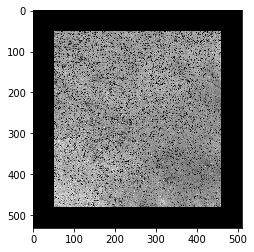

In [4]:
# Display
plt.imshow(ref_image, cmap='gray')

## Deform Ref Image

In [5]:
# Translate image in x
transx = np.array([[1.0, 0.0, 25.0],
                   [0.0, 1.0, 0.0]])
def_image = image_processing.im_warp(ref_image, transx)

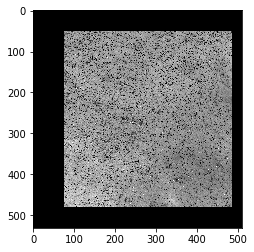

In [6]:
# Display
plt.imshow(def_image, cmap='gray')

## Manually Specify Region of Interest

In [7]:
# Format: [column index for start of X, column index for end of X, row index for start of Y, row index for end of Y]
subregion_indices = np.array([100, 400, 100, 400])

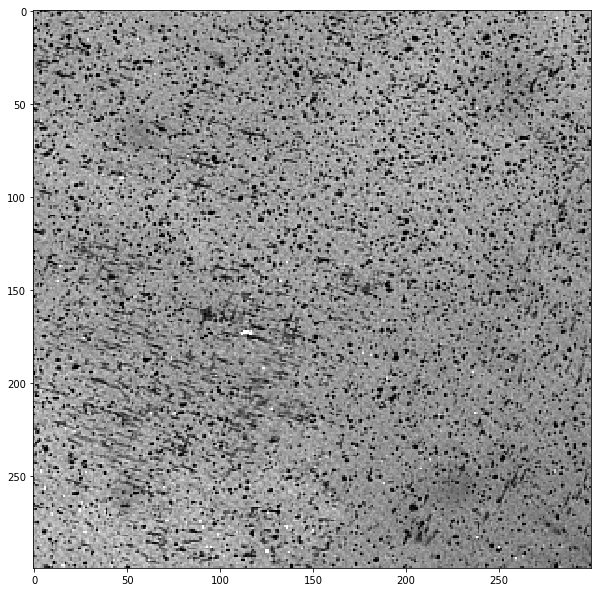

In [8]:
# Extract these regions from ref image and plot
ref_subimage = ref_image[subregion_indices[2]:subregion_indices[3], subregion_indices[0]:subregion_indices[1]]
fig, ax = plt.subplots(figsize=(10, 20))
ax.imshow(ref_subimage, cmap='gray')
plt.show()

## Setup reference mesh

In [9]:
# Control Points
rowmin = subregion_indices[-2:].min()
rowmax = subregion_indices[-2:].max()
colmin = subregion_indices[:2].min()
colmax = subregion_indices[:2].max()
x = np.linspace(colmin, colmax, 4)
y = np.linspace(rowmin, rowmax, 4)
coords = np.zeros((len(x) * len(y), 2))
k = 0
for i in range(0, len(x)):
    for j in range(0, len(y)):
        coords[k, :] = np.array([x[i], y[j]])
        k += 1

In [10]:
# Surface
ref_surf = bs.Surface()

ref_surf.degree_u = 3
ref_surf.degree_v = 3

num_ctrlpts = np.sqrt(len(coords)).astype('int')

ref_surf.set_ctrlpts(coords.tolist(), num_ctrlpts, num_ctrlpts)

ref_surf.knotvector_u = gutil.generate_knot_vector(ref_surf.degree_u, num_ctrlpts)
ref_surf.knotvector_v = gutil.generate_knot_vector(ref_surf.degree_v, num_ctrlpts)

ref_surf.delta = 0.001

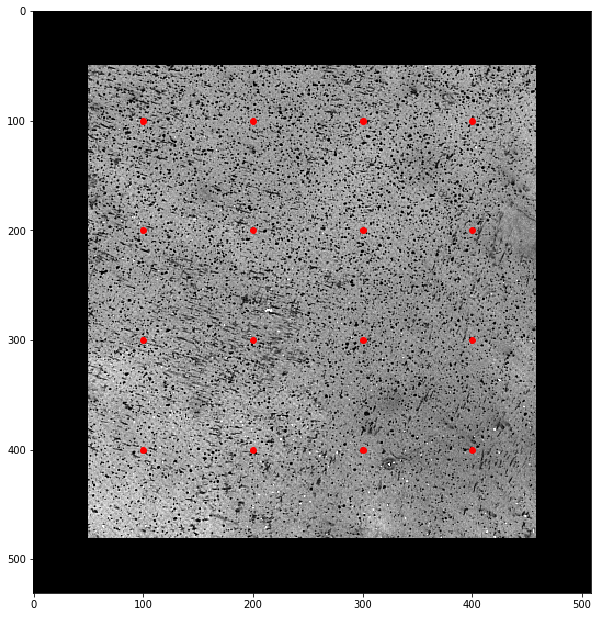

In [11]:
# Plot the mesh nodes on the original image
# Would be nice to be able to visualize full mesh
x = coords[:, 0]
y = coords[:, 1]
fig, ax = plt.subplots(figsize=(10, 20))
ax.imshow(ref_image, cmap='gray')
ax.plot(x, y, 'o', color='red')
plt.show()

## Interpolate images

In [12]:
ref_coeffs = numerics.image_interp(ref_image, degree='cubic')
def_coeffs = numerics.image_interp(def_image, degree='cubic')

## Test mesh znssd

In [13]:
# setup deformation
cpts_disp = np.column_stack((25 * np.ones(len(coords)), np.zeros(len(coords))))
foo = analysis.mesh_znssd(ref_image, def_image, ref_surf, cpts_disp, ref_coeff=ref_coeffs, def_coeff=def_coeffs)

IndexError: index 300 is out of bounds for axis 2 with size 300

## Wrap this minfun in scipy optimization library

### So this isn't really working either. Will need to figure out how to interpolate image